In [296]:

import torch
import torch_geometric
from torch_geometric.datasets import TUDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

### Import Dataset

In [297]:
dataset = TUDataset(root='datasets/', name='IMDB-BINARY')
torch.manual_seed(1234)
dataset = dataset.shuffle()

In [298]:
dataset

IMDB-BINARY(1000)

#### one hot encoding (degree)

In [299]:
max_degree = 0
degs = []
for data in dataset:
    deg = torch_geometric.utils.degree(data.edge_index[1], num_nodes=data.num_nodes)
    degs.extend(deg.numpy())
    max_degree = max(max_degree, max(deg).item())
# assign to one hot degree for each data (OneHotDegree receive maximum degree parameter)
dataset.transform = torch_geometric.transforms.OneHotDegree(int(max_degree))

### Preprocessing

#### Make dataset compatible with networkx, for Louvain algorithm

In [300]:
# edge transform
def edgeToTuple(edge):
    st = []
    for _, (s, d) in enumerate(zip(edge[0], edge[1])):
        st.append((s.item(), d.item()))
    return st

In [301]:
netx_graphs = []
for graph in dataset:
    G = nx.Graph(edgeToTuple(graph.edge_index))
    netx_graphs.append(G)

Sample


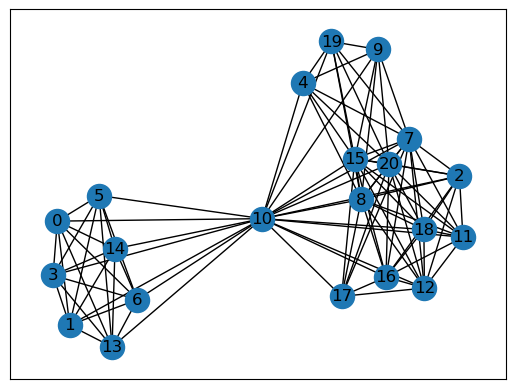

In [302]:
print('Sample')
nx.draw_networkx(netx_graphs[0])

#### Louvain Algorithm - Graph community detection

In [303]:
def makeCommunity(G):
    communities = nx.community.louvain_communities(G, seed=42)
    sub = []
    for c in communities:
        w = G.subgraph(c)
        # print(w.edges)
        sub.append(w.edges)
        # nx.draw_networkx(w, nx.spring_layout(G, seed=6))
    return sub

In [304]:
graph_subs = []
for G in netx_graphs:
    communities = makeCommunity(G)
    edge_from = []
    edge_to = []
    for c in communities:
        for edge in c:
            edge_from.append(edge[0])
            edge_to.append(edge[1])
    graph_subs.append(torch.tensor([edge_from,edge_to]))

In [305]:
graph_oris = []
for g in dataset:
    # print(g.edge_index[1])
    graph_oris.append([g.edge_index[0], g.edge_index[1]])

#### Data Description after preprocessing

1. List of edges, shows relation of pair of nodes ```from``` and ```to```. <br>
```graph_subs (list[tensor()])``` <br>
```graph_oris (list[tensor()])``` 

In [306]:
graph_subs[0][0]

tensor([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  3,  3,  3,  3,  3,
         5,  5,  5,  5,  6,  6,  6, 10, 10, 13,  2,  2,  2,  2,  2,  2,  2,  2,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,
         8,  8,  8, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 15, 15, 15, 15, 15,
        15, 15, 16, 16, 16, 18, 20, 20, 20, 20,  4,  4,  9])

In [307]:
graphs = []
for _, (ori, sub, target) in enumerate(zip(graph_oris, graph_subs, dataset)):
    # print(target.y)
    graphs.append([ori, sub, target.y])

```graphs[i]``` shows object of one graph <br>
```graphs[i][j]``` features of graph, ```j=0```: original edge index, ```j=1```: louvain subgraph, ```j=2```: graph target class

In [308]:
graphs[1]

[[tensor([ 0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,
           4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,
           8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11,
          11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15]),
  tensor([ 6,  7,  8,  2,  8, 11, 15,  1,  8, 11, 15,  5,  8,  9, 13,  8, 10, 12,
          14,  3,  8,  9, 13,  0,  7,  8,  0,  6,  8,  0,  1,  2,  3,  4,  5,  6,
           7,  9, 10, 11, 12, 13, 14, 15,  3,  5,  8, 13,  4,  8, 12, 14,  1,  2,
           8, 15,  4,  8, 10, 14,  3,  5,  8,  9,  4,  8, 10, 12,  1,  2,  8, 11])],
 tensor([[ 0,  0,  0,  8,  8,  6,  1,  1,  1,  2,  2, 11,  9,  9,  9,  5,  5,  3,
          10, 10, 10,  4,  4, 12],
         [ 6,  7,  8,  6,  7,  7,  2, 11, 15, 11, 15, 15,  3,  5, 13,  3, 13, 13,
           4, 12, 14, 12, 14, 14]]),
 tensor([1])]

### Train test split

In [309]:
yo = [d.y.item() for d in dataset]
ys = [Data(edge_index=d[1], y=d[2]) for d in graphs]
# yo == ys

In [310]:
subgraph_data = []
for _, (original, subgraph) in enumerate(zip(dataset, graphs)):
    subgraph_data.append(Data(edge_index=subgraph[1], x=original.x, y = original.y, num_nodes= original.num_nodes))

In [311]:
subgraph_data

[Data(x=[21, 136], edge_index=[2, 85], y=[1], num_nodes=21),
 Data(x=[16, 136], edge_index=[2, 24], y=[1], num_nodes=16),
 Data(x=[20, 136], edge_index=[2, 86], y=[1], num_nodes=20),
 Data(x=[24, 136], edge_index=[2, 53], y=[1], num_nodes=24),
 Data(x=[12, 136], edge_index=[2, 18], y=[1], num_nodes=12),
 Data(x=[14, 136], edge_index=[2, 42], y=[1], num_nodes=14),
 Data(x=[18, 136], edge_index=[2, 70], y=[1], num_nodes=18),
 Data(x=[18, 136], edge_index=[2, 50], y=[1], num_nodes=18),
 Data(x=[18, 136], edge_index=[2, 153], y=[1], num_nodes=18),
 Data(x=[12, 136], edge_index=[2, 30], y=[1], num_nodes=12),
 Data(x=[16, 136], edge_index=[2, 37], y=[1], num_nodes=16),
 Data(x=[14, 136], edge_index=[2, 26], y=[1], num_nodes=14),
 Data(x=[28, 136], edge_index=[2, 73], y=[1], num_nodes=28),
 Data(x=[20, 136], edge_index=[2, 190], y=[1], num_nodes=20),
 Data(x=[20, 136], edge_index=[2, 34], y=[1], num_nodes=20),
 Data(x=[21, 136], edge_index=[2, 100], y=[1], num_nodes=21),
 Data(x=[27, 136], ed

In [312]:
original_loader = DataLoader(dataset, batch_size=64, shuffle=False)
i = 0
for aa in original_loader:
    print(aa)
    i+=1
    if i == 1:
        break

DataBatch(edge_index=[2, 12108], y=[64], num_nodes=1200, x=[1200, 136], batch=[1200], ptr=[65])


In [313]:
aa

DataBatch(edge_index=[2, 12108], y=[64], num_nodes=1200, x=[1200, 136], batch=[1200], ptr=[65])

In [314]:
subgraph_loader = DataLoader(dataset=subgraph_data, batch_size=64, shuffle=False)
i = 0
for bb in subgraph_loader:
    print(bb)
    i+=1
    if i == 1:
        break

DataBatch(x=[1200, 136], edge_index=[2, 5277], y=[64], num_nodes=1200, batch=[1200], ptr=[65])


In [315]:
bb

DataBatch(x=[1200, 136], edge_index=[2, 5277], y=[64], num_nodes=1200, batch=[1200], ptr=[65])

Train test split

In [316]:
seed = 12345
ratio = 0.8
total = len(dataset)
# subgraph
subgraph_train = subgraph_data[:round(ratio*total)]
subgraph_test = subgraph_data[round(ratio*total):]

# original
original_train = dataset[:round(ratio*total)]
original_test = dataset[round(ratio*total):]

In [317]:
len(subgraph_train) == len(original_train) and len(subgraph_test) == len(original_test) 

True

Create data loader object

In [318]:
batch_size = 32
subgraph_train_loader = DataLoader(subgraph_train, batch_size=batch_size, shuffle=False)
subgraph_test_loader = DataLoader(subgraph_test, batch_size=batch_size, shuffle=False)

original_train_loader = DataLoader(original_train, batch_size=batch_size, shuffle=False)
original_test_loader = DataLoader(original_test, batch_size=batch_size, shuffle=False)

### Create Model

In [319]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear

from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import global_add_pool

In [389]:
class GraphSubgraphLearning(torch.nn.Module):
    # merging type: o --> complement only, s --> substraction, c --> concatenation
    def __init__(self, dataset, hidden_channels):
        super(GraphSubgraphLearning, self).__init__()
        
        # weight seed
        torch.manual_seed(42)
        self.conv1_o = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2_o = GCNConv(hidden_channels, hidden_channels)
        
        self.conv1_s = GCNConv(hidden_channels, hidden_channels)
        self.conv2_s = GCNConv(hidden_channels, hidden_channels)
        
        # classification layer
        
        self.lin = Linear(hidden_channels*2, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index_o, edge_index_s, batch_o, batch_s):
        
        # Embed original
        original_embedding = self.conv1_o(x, edge_index_o)
        original_embedding = original_embedding.relu()
        original_embedding = self.conv2_o(original_embedding, edge_index_o)
        # original_embedding = original_embedding.relu()
        
        # Embed Subgraph
        subgraph_embedding = self.conv1_s(original_embedding, edge_index_s)
        subgraph_embedding = subgraph_embedding.relu()
        subgraph_embedding = self.conv2_s(subgraph_embedding, edge_index_s)
        # subgraph_embedding = subgraph_embedding.relu()
        
        original_embedding = global_mean_pool(original_embedding, batch_o)
        subgraph_embedding = global_mean_pool(subgraph_embedding, batch_s)
        h = torch.cat((original_embedding, subgraph_embedding), 1)
        # h = h.relu()
        
        h = self.lin(h)
        h.relu()
        h = self.lin2(h)
        
        return original_embedding, subgraph_embedding, h

In [390]:
model = GraphSubgraphLearning(dataset, 64)

In [391]:
model

GraphSubgraphLearning(
  (conv1_o): GCNConv(136, 64)
  (conv2_o): GCNConv(64, 64)
  (conv1_s): GCNConv(64, 64)
  (conv2_s): GCNConv(64, 64)
  (lin): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [392]:
embed = None
for _, (dt, ds) in enumerate(zip(original_train_loader, subgraph_train_loader)):
    print(dt)
    print(ds.batch)
    embed = model(dt.x, dt.edge_index, ds.edge_index, dt.batch, ds.batch)
    break

DataBatch(edge_index=[2, 5480], y=[32], num_nodes=570, x=[570, 136], batch=[570], ptr=[33])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 

Training

In [393]:
def train(model, original_train_loader, subgraph_train_loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    
    for _, (do, ds) in enumerate(zip(original_train_loader, subgraph_train_loader)):
        _,_, h = model(do.x, do.edge_index, ds.edge_index, do.batch, ds.batch)
        loss = criterion(h, do.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

@torch.no_grad()
def test(model, original_test_loader, subgraph_test_loader):
    model.eval()
    correct = 0
    for _, (do, ds) in enumerate(zip(original_test_loader, subgraph_test_loader)):
        _,_, h = model(do.x, do.edge_index, ds.edge_index, do.batch, ds.batch)
        pred = h.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct/len(original_test_loader.dataset)


In [394]:
list_train_acc = []
list_test_acc = []
list_loss = []

epoch = 100
for epoch in range(0, epoch):
    loss = train(model, original_train_loader, subgraph_train_loader)
    train_acc = test(model, original_train_loader, original_train_loader)
    test_acc = test(model, original_test_loader, subgraph_test_loader)
    
    list_train_acc.append(round(train_acc, 4))
    list_test_acc.append(round(test_acc, 4))
    list_loss.append(round(loss.item(), 4))

    print(f"epoch: {epoch+1} train_acc: {train_acc:.4f} loss: {loss:.4f} test_acc: {test_acc:.4f}")


epoch: 1 train_acc: 0.4462 loss: 0.4837 test_acc: 0.5200
epoch: 2 train_acc: 0.3962 loss: 0.4978 test_acc: 0.4850
epoch: 3 train_acc: 0.3738 loss: 0.4899 test_acc: 0.3950
epoch: 4 train_acc: 0.3775 loss: 0.4285 test_acc: 0.3900
epoch: 5 train_acc: 0.3887 loss: 0.4625 test_acc: 0.3900
epoch: 6 train_acc: 0.3563 loss: 0.4647 test_acc: 0.3700
epoch: 7 train_acc: 0.3937 loss: 0.4353 test_acc: 0.4100
epoch: 8 train_acc: 0.3050 loss: 0.4499 test_acc: 0.3400
epoch: 9 train_acc: 0.3337 loss: 0.4521 test_acc: 0.3500
epoch: 10 train_acc: 0.3762 loss: 0.4555 test_acc: 0.3850
epoch: 11 train_acc: 0.4313 loss: 0.5243 test_acc: 0.4250
epoch: 12 train_acc: 0.4725 loss: 0.4614 test_acc: 0.4900
epoch: 13 train_acc: 0.3787 loss: 0.4588 test_acc: 0.3950
epoch: 14 train_acc: 0.3275 loss: 0.4966 test_acc: 0.3250
epoch: 15 train_acc: 0.3613 loss: 0.4726 test_acc: 0.3600
epoch: 16 train_acc: 0.3475 loss: 0.4594 test_acc: 0.3050
epoch: 17 train_acc: 0.2725 loss: 0.4715 test_acc: 0.2650
epoch: 18 train_acc: 0.

## Base Model

In [397]:
class Base(torch.nn.Module):
    # merging type: o --> complement only, s --> substraction, c --> concatenation
    def __init__(self, dataset, hidden_channels):
        super(Base, self).__init__()
        
        # weight seed
        torch.manual_seed(42)
        self.conv1_o = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2_o = GCNConv(hidden_channels, hidden_channels)
        # classification layer
        
        self.lin = Linear(hidden_channels*2, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index_o, batch_o):
        # Embed original
        original_embedding = self.conv1_o(x, edge_index_o)
        original_embedding = original_embedding.relu()
        original_embedding = self.conv2_o(original_embedding, edge_index_o)
        # subgraph_embedding = subgraph_embedding.relu()
        
        original_embedding = global_mean_pool(original_embedding, batch_o)
        h = self.lin(h)
        h.relu()
        h = self.lin2(h)
        
        return original_embedding, h

In [398]:
base = Base(dataset, 64)

In [399]:
base

Base(
  (conv1_o): GCNConv(136, 64)
  (conv2_o): GCNConv(64, 64)
  (lin): Linear(in_features=128, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [402]:
def train_base(model, original_train_loader):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    model.train()
    
    for do in original_train_loader:
        _,_, h = model(do.x, do.edge_index, do.batch)
        loss = criterion(h, do.y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return loss

@torch.no_grad()
def test_base(model, original_test_loader):
    model.eval()
    correct = 0
    for do in original_train_loader:
        _,_, h = model(do.x, do.edge_index, do.batch)
        pred = h.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct/len(original_test_loader.dataset)
